FTEC5580 Project 2 Part 3 FNN \
Name: Man Yat Fu\
SID:1155109353



In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample 
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE,SelectFromModel
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.neural_network import MLPClassifier
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_cumulative_gain
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier ,ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_auc_score,roc_curve,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")


<h1>Data Processing

In [2]:
filename = "UCI_Credit_Card.csv"

In [3]:
df = pd.read_csv(filename)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Setup tags for input data and categorization.

In [4]:
input_cols=['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

output_cols='default.payment.next.month'

categorical_cols=['SEX', 'EDUCATION', 'MARRIAGE',  'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
cont_cols=['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2','AGE',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [5]:
def df_to_arrays(df):
    df1 = df.copy(deep=True)
    for col in categorical_cols:
        df1[col] = df1[col].astype('category').cat.codes
    inputs_array = df1[input_cols].to_numpy()
    targets_array = df1[output_cols].to_numpy()
    return inputs_array, targets_array

In [6]:
inputs_array, targets_array = df_to_arrays(df)
inputs = torch.from_numpy(np.array(inputs_array,dtype=np.float32))
targets = torch.from_numpy(np.array(targets_array,dtype=np.float32))
dataset = TensorDataset(inputs, targets)

val_percent = 0.2 
num_rows=len(df)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset,[train_size,val_size])

Create data loaders for training & validation.

In [7]:
batch_size = 16
input_size = len(input_cols)
num_classes=2

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
# for xb, yb in train_loader:
#     print("inputs:", xb)
#     print("targets:", yb)
#     break  

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Train the model to fit the data

In [9]:
class CreditModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.linear2 = nn.Linear(16,8)
        self.linear3 = nn.Linear(8,4)
        self.linear_out = nn.Linear(4,num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        self.batchnorm3 = nn.BatchNorm1d(4)
        
    def forward(self, inputs):
        x = self.sigmoid(self.linear1(inputs))
        x = self.batchnorm1(x)
        x = self.sigmoid(self.linear2(x))
        x = self.batchnorm2(x)
        x = self.sigmoid(self.linear3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.linear_out(x)
        
        return x

    def training_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                 
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)               
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean() 
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = CreditModel()
model

CreditModel(
  (linear1): Linear(in_features=23, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=4, bias=True)
  (linear_out): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
class CreditModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.linear2 = nn.Linear(16,8)
        self.linear3 = nn.Linear(8,4)
        self.dropout = nn.Dropout(p=0.5)
        self.linear_out = nn.Linear(4,num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.sigmoid(self.linear1(inputs))
        x = self.sigmoid(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        x = self.linear_out(x)
        
        return x

    
    def training_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                    
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch_sigmoid [{}], val_loss_sigmoid: {:.4f}, val_acc_sigmoid: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = CreditModel()
model

CreditModel(
  (linear1): Linear(in_features=23, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=4, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [11]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            images, labels = batch
            out = model(images)
            labels=labels.type(torch.long)
            loss = F.cross_entropy(out, labels)   
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [12]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 0.6049247980117798, 'val_acc': 0.7731666564941406}


In [13]:
epochs = 3
lr = 1e-3
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch_sigmoid [0], val_loss_sigmoid: 0.5412, val_acc_sigmoid: 0.7732
Epoch_sigmoid [1], val_loss_sigmoid: 0.5359, val_acc_sigmoid: 0.7732
Epoch_sigmoid [2], val_loss_sigmoid: 0.5355, val_acc_sigmoid: 0.7732


In [14]:
class CreditModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256,128)
        self.linear3 = nn.Linear(128,32)
        self.linear4 = nn.Linear(32,8)
        
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.5)

        self.linear_out = nn.Linear(8,num_classes)
        
    def forward(self, inputs):
        x = self.softmax(self.linear1(inputs))
        x = self.softmax(self.linear2(x))
        x = self.softmax(self.linear3(x))
        x = self.softmax(self.linear4(x))
        
        x = self.dropout(x)
        x = self.linear_out(x)
        
        return x

    
    def training_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                  
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels=labels.type(torch.long)
        out = self(images)                   
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch_softmax [{}], val_loss_softmax: {:.4f}, val_acc_softmax: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model_softmax = CreditModel()
model_softmax

CreditModel(
  (linear1): Linear(in_features=23, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=8, bias=True)
  (softmax): Softmax(dim=None)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_out): Linear(in_features=8, out_features=2, bias=True)
)

In [15]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            images, labels = batch
            out = model(images)
            labels=labels.type(torch.long)
            #             loss = model.training_step(batch)
            loss = F.cross_entropy(out, labels)   #y_batch.unsqueeze(1)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
result = evaluate(model_softmax,val_loader) # Use the the evaluate function
print(result)
epochs = 4
lr = 1e-3
history = fit(epochs, lr, model_softmax, train_loader, val_loader)

{'val_loss': 0.650579035282135, 'val_acc': 0.7731666564941406}
Epoch_softmax [0], val_loss_softmax: 0.5598, val_acc_softmax: 0.7732
Epoch_softmax [1], val_loss_softmax: 0.5420, val_acc_softmax: 0.7732
Epoch_softmax [2], val_loss_softmax: 0.5366, val_acc_softmax: 0.7732
Epoch_softmax [3], val_loss_softmax: 0.5361, val_acc_softmax: 0.7732


val_loss = 0.5014 #with 10 epochs and 1e-3 learning rate for ReLU sounds better than sigmoid. 
However, ReLU took more time than sigmoid so we will use Sigmoid since the difference in accuracy is only slight.

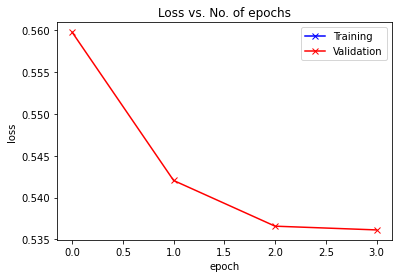

In [17]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

After 2 epochs, the model loss doesn't improve significantly as can be seen.

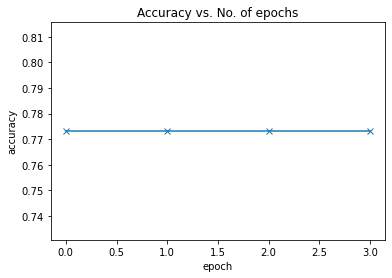

In [18]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

## Conclusion:

According to above result,  we got an accuracy with 78%.